# MIDI Music Generation with PyTorch LSTM

A medium-sized deep learning model for generating polyphonic piano music from MIDI files.

**Architecture:** LSTM-based sequence model (~3M parameters)  
**Dataset:** ADL Piano MIDI (diverse genres)  
**Output:** Generated MIDI files

## Sources & References
- [ADL Piano MIDI](https://github.com/lucasnfe/adl-piano-midi)
- [Lakh MIDI Dataset](https://colinraffel.com/projects/lmd/)
- [Aria-MIDI on HuggingFace](https://huggingface.co/datasets/loubb/aria-midi)

## 1. Setup and Dependencies

In [1]:
# Install required packages (run once)
# !pip install torch numpy pretty_midi matplotlib tqdm requests

In [2]:
import os
import json
import random
import requests
import zipfile
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import pretty_midi
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device configuration with Apple Silicon and CUCA optimizations
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    # Enable MPS fallback for unsupported ops
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
    print(f"Using Apple Silicon MPS (Metal Performance Shaders)")
    print(f"  Unified Memory: Full RAM available to GPU")
else:
    DEVICE = torch.device('cpu')
    print("Using CPU")

# Check PyTorch version for torch.compile support
TORCH_VERSION = tuple(map(int, torch.__version__.split('.')[:2]))
USE_COMPILE = TORCH_VERSION >= (2, 0) and DEVICE.type != 'mps'  # compile has limited MPS support
print(f"PyTorch version: {torch.__version__}")

Using Apple Silicon MPS (Metal Performance Shaders)
  Unified Memory: Full RAM available to GPU
PyTorch version: 2.9.1


## 2. Load ADL Piano MIDI Dataset

Using the ADL Piano MIDI dataset - a curated collection of piano MIDI files organized by genre.

**Dataset Info:**
- ~11,000 piano MIDI files
- Organized by Genre/Subgenre/Artist/Song
- Contains actual time signature metadata (4/4, 3/4, etc.)
- 1-2 tracks per file (left/right hand)
- We generate train/validation/test splits (80/10/10)

In [3]:
# Configuration
DATA_DIR = Path("./midi_data")
ADL_DIR = DATA_DIR / "adl-piano-midi"

def load_adl_piano_midi(adl_dir: Path) -> List[dict]:
    """
    Load ADL Piano MIDI dataset.
    
    Returns list of dicts with path, genre, subgenre, artist, title.
    """
    files = []
    
    for midi_path in adl_dir.rglob("*.mid"):
        # Extract metadata from directory structure: Genre/Subgenre/Artist/Song.mid
        parts = midi_path.relative_to(adl_dir).parts
        
        if len(parts) >= 4:
            genre, subgenre, artist = parts[0], parts[1], parts[2]
        elif len(parts) >= 3:
            genre, subgenre, artist = parts[0], parts[1], "Unknown"
        elif len(parts) >= 2:
            genre, subgenre, artist = parts[0], "Unknown", "Unknown"
        else:
            genre, subgenre, artist = "Unknown", "Unknown", "Unknown"
        
        files.append({
            "path": midi_path,
            "genre": genre,
            "subgenre": subgenre,
            "artist": artist,
            "title": midi_path.stem
        })
    
    return files


def create_splits(files: List[dict], train_ratio: float = 0.8, 
                  val_ratio: float = 0.1, seed: int = 42) -> dict:
    """
    Create train/validation/test splits.
    
    Shuffles files and splits by ratio. Uses seed for reproducibility.
    """
    random.seed(seed)
    shuffled = files.copy()
    random.shuffle(shuffled)
    
    n = len(shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return {
        "train": shuffled[:train_end],
        "validation": shuffled[train_end:val_end],
        "test": shuffled[val_end:]
    }


# Load all ADL files
all_adl_files = load_adl_piano_midi(ADL_DIR)
print(f"Found {len(all_adl_files)} MIDI files in ADL Piano MIDI dataset")

# Show genre distribution
genre_counts = {}
for f in all_adl_files:
    genre_counts[f["genre"]] = genre_counts.get(f["genre"], 0) + 1
print(f"\nGenre distribution:")
for genre, count in sorted(genre_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  {genre}: {count} files")

Found 11076 MIDI files in ADL Piano MIDI dataset

Genre distribution:
  Rock: 3137 files
  Unknown: 2171 files
  Classical: 1398 files
  Soundtracks: 947 files
  Pop: 750 files
  World: 503 files
  Jazz: 492 files
  Soul: 351 files
  Latin: 253 files
  Country: 246 files


In [4]:
# Create train/validation/test splits
adl_splits = create_splits(all_adl_files, train_ratio=0.8, val_ratio=0.1, seed=SEED)

print("ADL Piano MIDI Dataset splits:")
print(f"  Train:      {len(adl_splits['train'])} files")
print(f"  Validation: {len(adl_splits['validation'])} files")
print(f"  Test:       {len(adl_splits['test'])} files")
print(f"  Total:      {sum(len(v) for v in adl_splits.values())} files")

# Preview examples from each split
for split_name, files in adl_splits.items():
    if files:
        example = files[0]
        print(f"\n{split_name.upper()} example:")
        print(f"  Genre: {example['genre']} / {example['subgenre']}")
        print(f"  Artist: {example['artist']}")
        print(f"  Title: {example['title']}")

ADL Piano MIDI Dataset splits:
  Train:      8860 files
  Validation: 1108 files
  Test:       1108 files
  Total:      11076 files

TRAIN example:
  Genre: Rap / Rap Latina
  Artist: Mala
  Title: Terima Kasih

VALIDATION example:
  Genre: Classical / Classical Era
  Artist: Jan Ladislav Dussek
  Title: Opus 46 no 6 4

TEST example:
  Genre: Unknown / Unknown
  Artist: Lucha Villa Con El Mariachi Vargas De Tecalitlan
  Title: La Llorona


### 2.1 Dataset Structure Analysis

Analyze the time signatures and tempos in ADL Piano MIDI to understand the musical structure.
This helps us decide whether to filter for specific time signatures (e.g., 4/4 only) 
and choose appropriate bar-aligned strides for training.

In [5]:
def analyze_midi_structure(midi_files: List[dict], config: dict) -> List[dict]:
    """
    Analyze time signature and tempo for all MIDI files.
    
    Returns:
        List of dicts with path, tempo, time_sig, frames_per_bar for each piece
    """
    results = []
    errors = 0
    
    for file_info in tqdm(midi_files, desc="Analyzing structure"):
        try:
            midi = pretty_midi.PrettyMIDI(str(file_info["path"]))
            
            # Estimate tempo
            tempo = midi.estimate_tempo()
            
            # Get time signature (first one, or default 4/4)
            time_sigs = midi.time_signature_changes
            if time_sigs:
                numerator = time_sigs[0].numerator
                denominator = time_sigs[0].denominator
            else:
                numerator, denominator = 4, 4
            
            # Calculate frames per bar
            seconds_per_beat = 60.0 / tempo
            beats_per_bar = numerator
            seconds_per_bar = seconds_per_beat * beats_per_bar
            frames_per_bar = seconds_per_bar * config["fs"]
            
            results.append({
                "path": file_info["path"].name,
                "genre": file_info.get("genre", "Unknown"),
                "tempo": tempo,
                "time_sig": f"{numerator}/{denominator}",
                "numerator": numerator,
                "denominator": denominator,
                "frames_per_bar": frames_per_bar,
            })
        except Exception as e:
            errors += 1
            continue
    
    if errors > 0:
        print(f"Warning: {errors} files could not be analyzed")
    
    return results


def summarize_structure_analysis(analysis: List[dict]) -> dict:
    """
    Summarize the structure analysis with counts and statistics.
    """
    if not analysis:
        return {"total_pieces": 0, "time_sig_counts": {}, "tempo_min": 0, 
                "tempo_max": 0, "tempo_mean": 0, "tempo_median": 0,
                "frames_per_bar_4_4_mean": 0, "frames_per_bar_4_4_median": 0}
    
    # Count time signatures
    time_sig_counts = {}
    for item in analysis:
        ts = item["time_sig"]
        time_sig_counts[ts] = time_sig_counts.get(ts, 0) + 1
    
    # Sort by count
    time_sig_counts = dict(sorted(time_sig_counts.items(), key=lambda x: -x[1]))
    
    # Tempo statistics
    tempos = [item["tempo"] for item in analysis]
    
    # Frames per bar statistics (for 4/4 pieces only)
    fpb_4_4 = [item["frames_per_bar"] for item in analysis if item["time_sig"] == "4/4"]
    
    return {
        "total_pieces": len(analysis),
        "time_sig_counts": time_sig_counts,
        "tempo_min": min(tempos) if tempos else 0,
        "tempo_max": max(tempos) if tempos else 0,
        "tempo_mean": np.mean(tempos) if tempos else 0,
        "tempo_median": np.median(tempos) if tempos else 0,
        "frames_per_bar_4_4_mean": np.mean(fpb_4_4) if fpb_4_4 else 0,
        "frames_per_bar_4_4_median": np.median(fpb_4_4) if fpb_4_4 else 0,
    }

In [6]:
# Define config for analysis
ANALYSIS_CONFIG = {"fs": 16}  # Frames per second - needed for frames_per_bar calculation

# Analyze all files (from all splits)
all_files = adl_splits["train"] + adl_splits["validation"] + adl_splits["test"]
structure_analysis = analyze_midi_structure(all_files, ANALYSIS_CONFIG)
summary = summarize_structure_analysis(structure_analysis)

# Print summary
print("=" * 60)
print("ADL Piano MIDI Dataset Structure Analysis")
print("=" * 60)
print(f"\nTotal pieces analyzed: {summary['total_pieces']}")

print(f"\n{'TIME SIGNATURES':=^60}")
for ts, count in summary["time_sig_counts"].items():
    pct = count / summary["total_pieces"] * 100
    bar = "█" * int(pct / 2)
    print(f"  {ts:>5s}: {count:4d} pieces ({pct:5.1f}%) {bar}")

print(f"\n{'TEMPO (BPM)':=^60}")
print(f"  Min:    {summary['tempo_min']:6.1f} BPM")
print(f"  Max:    {summary['tempo_max']:6.1f} BPM")
print(f"  Mean:   {summary['tempo_mean']:6.1f} BPM")
print(f"  Median: {summary['tempo_median']:6.1f} BPM")

print(f"\n{'FRAMES PER BAR (4/4 pieces only)':=^60}")
print(f"  Mean:   {summary['frames_per_bar_4_4_mean']:6.1f} frames")
print(f"  Median: {summary['frames_per_bar_4_4_median']:6.1f} frames")
print(f"  (At 16 fps, 32 frames = 2 seconds = 1 bar at 120 BPM)")

Analyzing structure:   0%|          | 0/11076 [00:00<?, ?it/s]

/Users/chrigel/Documents/workspace/private/bfh/midi-gen/venv/lib/python3.14/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


ADL Piano MIDI Dataset Structure Analysis

Total pieces analyzed: 10971

======================TIME SIGNATURES=======================
    4/4: 9065 pieces ( 82.6%) █████████████████████████████████████████
    3/4:  696 pieces (  6.3%) ███
    2/4:  492 pieces (  4.5%) ██
    6/8:  266 pieces (  2.4%) █
    2/2:  102 pieces (  0.9%) 
   12/8:   80 pieces (  0.7%) 
    1/4:   56 pieces (  0.5%) 
    6/4:   49 pieces (  0.4%) 
    3/8:   46 pieces (  0.4%) 
    5/4:   28 pieces (  0.3%) 
    8/8:   15 pieces (  0.1%) 
    9/8:   15 pieces (  0.1%) 
    3/2:   13 pieces (  0.1%) 
    5/8:    6 pieces (  0.1%) 
    8/4:    6 pieces (  0.1%) 
    4/8:    5 pieces (  0.0%) 
    1/8:    5 pieces (  0.0%) 
    7/8:    3 pieces (  0.0%) 
    7/4:    3 pieces (  0.0%) 
   10/8:    2 pieces (  0.0%) 
   1/16:    2 pieces (  0.0%) 
   9/16:    2 pieces (  0.0%) 
    4/2:    2 pieces (  0.0%) 
   13/8:    2 pieces (  0.0%) 
   12/4:    2 pieces (  0.0%) 
   11/8:    1 pieces (  0.0%) 
  12/16:    1

In [7]:
# Optional: Filter dataset by time signature and tempo
# ADL has real time signature metadata, so filtering actually works!

FILTER_4_4 = False  # Set to True to filter for 4/4 time signature only
FILTER_TEMPO_MIN = None  # Set to e.g. 80 to filter slow pieces
FILTER_TEMPO_MAX = None  # Set to e.g. 160 to filter fast pieces

def filter_by_structure(splits: dict, analysis: List[dict], 
                        time_sig: str = None,
                        tempo_min: float = None, 
                        tempo_max: float = None) -> dict:
    """
    Filter splits by time signature and/or tempo range.
    """
    # Build lookup from filename to analysis
    analysis_lookup = {item["path"]: item for item in analysis}
    
    filtered_splits = {"train": [], "validation": [], "test": []}
    
    for split_name, files in splits.items():
        for file_info in files:
            filename = file_info["path"].name
            if filename not in analysis_lookup:
                continue
            
            item = analysis_lookup[filename]
            
            # Apply filters
            if time_sig and item["time_sig"] != time_sig:
                continue
            if tempo_min and item["tempo"] < tempo_min:
                continue
            if tempo_max and item["tempo"] > tempo_max:
                continue
            
            # Add tempo info to file_info for later use
            filtered_splits[split_name].append({
                **file_info,
                "tempo": item["tempo"],
                "time_sig": item["time_sig"],
                "frames_per_bar": item["frames_per_bar"]
            })
    
    return filtered_splits


# Apply filters if enabled
if FILTER_4_4 or FILTER_TEMPO_MIN or FILTER_TEMPO_MAX:
    adl_splits_filtered = filter_by_structure(
        adl_splits, 
        structure_analysis,
        time_sig="4/4" if FILTER_4_4 else None,
        tempo_min=FILTER_TEMPO_MIN,
        tempo_max=FILTER_TEMPO_MAX
    )
    
    print("Filtered dataset:")
    for split_name, files in adl_splits_filtered.items():
        orig_count = len(adl_splits[split_name])
        new_count = len(files)
        pct = new_count/orig_count*100 if orig_count > 0 else 0
        print(f"  {split_name:12s}: {new_count:4d} / {orig_count:4d} pieces ({pct:.1f}%)")
    
    # Replace the original splits
    adl_splits = adl_splits_filtered
    print("\n→ Using filtered dataset for training")
else:
    print("No filtering applied. Using full dataset.")
    print("Set FILTER_4_4 = True above to filter for 4/4 time signature only.")

No filtering applied. Using full dataset.
Set FILTER_4_4 = True above to filter for 4/4 time signature only.


In [8]:
# Dataset size configuration
# For quick demos: 30-50 files, ~30-60 min training
# For good results: None (all files), 4-8 hours training
# For best results: All files + 100+ epochs, overnight

MAX_FILES_PER_SPLIT = 50  # Set to None for full dataset

if MAX_FILES_PER_SPLIT:
    for split in adl_splits:
        adl_splits[split] = adl_splits[split][:MAX_FILES_PER_SPLIT]
    print(f"QUICK MODE: Limited to {MAX_FILES_PER_SPLIT} files per split")
    print("  → Expect ~30-60 min training, basic but audible results")
else:
    print("FULL MODE: Using all files")
    print("  → Expect 2-8 hours training, better quality results")

QUICK MODE: Limited to 50 files per split
  → Expect ~30-60 min training, basic but audible results


## 3. MIDI Preprocessing

Convert MIDI files to a piano roll representation suitable for polyphonic music generation.

In [9]:
# Hyperparameters for MIDI processing
MIDI_CONFIG = {
    "min_pitch": 21,       # A0 (lowest piano key)
    "max_pitch": 108,      # C8 (highest piano key)
    "fs": 16,              # Frames per second (temporal resolution)
    "velocity_bins": 32,   # Velocity quantization bins
    "max_duration": 60,    # Max clip duration in seconds
}

NUM_PITCHES = MIDI_CONFIG["max_pitch"] - MIDI_CONFIG["min_pitch"] + 1  # 88 piano keys
print(f"Number of pitches: {NUM_PITCHES}")

Number of pitches: 88


In [10]:
def midi_to_piano_roll(midi_path: Path, config: dict) -> Optional[np.ndarray]:
    """
    Convert a MIDI file to a piano roll representation.
    
    Merges all instrument tracks (left/right hand, or multiple instruments)
    into a single piano roll.
    
    Returns:
        numpy array of shape (time_steps, num_pitches) with velocity values [0, 1]
    """
    try:
        midi = pretty_midi.PrettyMIDI(str(midi_path))
    except Exception as e:
        print(f"Error loading {midi_path}: {e}")
        return None
    
    # Clip duration
    end_time = min(midi.get_end_time(), config["max_duration"])
    if end_time < 1.0:
        return None
    
    # Get piano roll - this automatically merges all instrument tracks
    # Shape: (128, time_steps) with velocity values 0-127
    piano_roll = midi.get_piano_roll(fs=config["fs"])
    
    # Crop to piano range and duration
    max_frames = int(config["max_duration"] * config["fs"])
    piano_roll = piano_roll[config["min_pitch"]:config["max_pitch"]+1, :max_frames]
    
    # Normalize velocities to [0, 1]
    piano_roll = piano_roll / 127.0
    
    # Clip overlapping notes that exceed 1.0 (ADL dataset has summed velocities)
    piano_roll = np.clip(piano_roll, 0, 1)
    
    # Transpose to (time, pitch)
    piano_roll = piano_roll.T
    
    return piano_roll.astype(np.float32)


# Quick test on a sample file
sample_file = adl_splits["train"][0]["path"]
sample_roll = midi_to_piano_roll(sample_file, MIDI_CONFIG)
if sample_roll is not None:
    print(f"Sample piano roll shape: {sample_roll.shape}")
    print(f"  Duration: {sample_roll.shape[0] / MIDI_CONFIG['fs']:.1f}s")
    print(f"  Non-zero frames: {(sample_roll.sum(axis=1) > 0).sum()}")
    print(f"  Value range: [{sample_roll.min():.2f}, {sample_roll.max():.2f}]")  # Verify clipping
else:
    print("Failed to load sample file")

Sample piano roll shape: (960, 88)
  Duration: 60.0s
  Non-zero frames: 910
  Value range: [0.00, 1.00]


In [44]:
def piano_roll_to_midi(piano_roll: np.ndarray, config: dict, 
                       output_path: Path, velocity_threshold: float = 0.3) -> None:
    """
    Convert a piano roll back to a MIDI file.
    
    Args:
        piano_roll: Array of shape (time_steps, num_pitches) with values in [0, 1]
        config: MIDI configuration dictionary
        output_path: Path to save the MIDI file
        velocity_threshold: Minimum velocity to consider a note as "on"
    """
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano
    
    frame_duration = 1.0 / config["fs"]
    active_notes = {}  # pitch -> (start_time, velocity)
    
    for frame_idx, frame in enumerate(piano_roll):
        current_time = frame_idx * frame_duration
        
        for pitch_idx, velocity in enumerate(frame):
            midi_pitch = pitch_idx + config["min_pitch"]
            is_note_on = velocity > velocity_threshold
            
            if midi_pitch in active_notes:
                # Note was on - check if it should end
                if not is_note_on:
                    start_time, start_vel = active_notes.pop(midi_pitch)
                    note = pretty_midi.Note(
                        velocity=int(start_vel * 127),
                        pitch=midi_pitch,
                        start=start_time,
                        end=current_time
                    )
                    piano.notes.append(note)
            else:
                # Note was off - check if it should start
                if is_note_on:
                    active_notes[midi_pitch] = (current_time, velocity)
    
    # Close any remaining active notes
    end_time = len(piano_roll) * frame_duration
    for midi_pitch, (start_time, velocity) in active_notes.items():
        note = pretty_midi.Note(
            velocity=int(velocity * 127),
            pitch=midi_pitch,
            start=start_time,
            end=end_time
        )
        piano.notes.append(note)
    
    midi.instruments.append(piano)
    midi.write(str(output_path))
    
print("piano_roll_to_midi function defined")

piano_roll_to_midi function defined


In [11]:
# Process MIDI files for each split
piano_rolls_by_split = {"train": [], "validation": [], "test": []}

for split_name, files in adl_splits.items():
    print(f"\nProcessing {split_name} set...")
    for file_info in tqdm(files, desc=f"  {split_name}"):
        roll = midi_to_piano_roll(file_info["path"], MIDI_CONFIG)
        if roll is not None and len(roll) > 100:  # Minimum length
            piano_rolls_by_split[split_name].append(roll)

print("\n" + "="*50)
print("Processed piano rolls:")
for split_name, rolls in piano_rolls_by_split.items():
    total_frames = sum(len(r) for r in rolls)
    total_duration = total_frames / MIDI_CONFIG["fs"]
    print(f"  {split_name:12s}: {len(rolls):4d} files, {total_duration/60:.1f} minutes of music")


Processing train set...


  train:   0%|          | 0/50 [00:00<?, ?it/s]


Processing validation set...


  validation:   0%|          | 0/50 [00:00<?, ?it/s]


Processing test set...


  test:   0%|          | 0/50 [00:00<?, ?it/s]


Processed piano rolls:
  train       :   50 files, 49.3 minutes of music
  validation  :   50 files, 47.9 minutes of music
  test        :   50 files, 49.7 minutes of music


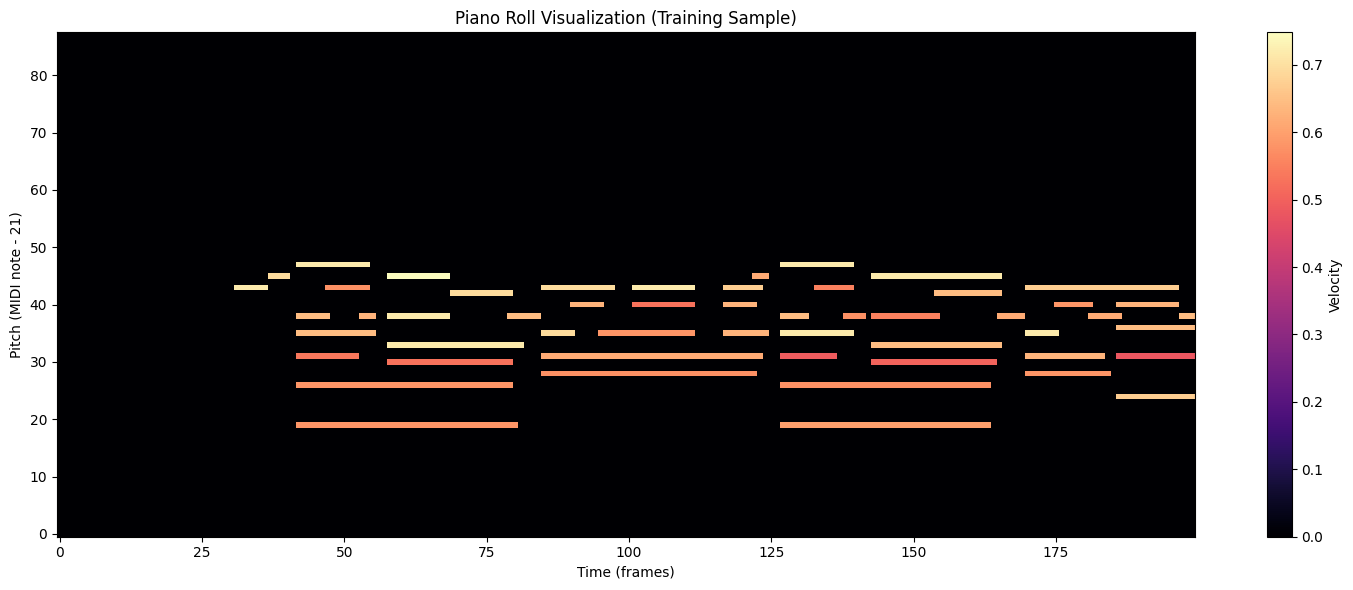

In [12]:
# Visualize a piano roll from the training set
if piano_rolls_by_split["train"]:
    sample_roll = piano_rolls_by_split["train"][0][:200]  # First 200 frames
    
    plt.figure(figsize=(15, 6))
    plt.imshow(sample_roll.T, aspect='auto', origin='lower', cmap='magma')
    plt.xlabel('Time (frames)')
    plt.ylabel('Pitch (MIDI note - 21)')
    plt.title('Piano Roll Visualization (Training Sample)')
    plt.colorbar(label='Velocity')
    plt.tight_layout()
    plt.show()

## 4. Dataset and DataLoader

In [13]:
# Training hyperparameters
SEQUENCE_LENGTH = 64   # Input sequence length
STRIDE = 16            # Sliding window stride

# Apple Silicon optimization: Use larger batch sizes
# Unified memory allows larger batches without OOM
if DEVICE.type == 'mps':
    BATCH_SIZE = 64    # Larger batch for MPS (unified memory)
elif DEVICE.type == 'cuda':
    BATCH_SIZE = 64    # Adjust based on GPU memory
else:
    BATCH_SIZE = 32    # CPU fallback

print(f"Batch size: {BATCH_SIZE} (optimized for {DEVICE.type})")

Batch size: 64 (optimized for mps)


In [14]:
class MidiDataset(Dataset):
    """
    PyTorch Dataset for MIDI piano roll sequences.
    
    Creates overlapping sequences using a sliding window approach.
    """
    
    def __init__(self, piano_rolls: List[np.ndarray], 
                 sequence_length: int, stride: int):
        self.sequences = []
        self.targets = []
        
        for roll in piano_rolls:
            # Extract sequences with sliding window
            for i in range(0, len(roll) - sequence_length - 1, stride):
                seq = roll[i:i + sequence_length]
                target = roll[i + 1:i + sequence_length + 1]
                self.sequences.append(seq)
                self.targets.append(target)
        
        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)
        
    def __len__(self) -> int:
        return len(self.sequences)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return (
            torch.FloatTensor(self.sequences[idx]),
            torch.FloatTensor(self.targets[idx])
        )

In [15]:
# Create datasets using ADL splits
train_dataset = MidiDataset(piano_rolls_by_split["train"], SEQUENCE_LENGTH, STRIDE)
val_dataset = MidiDataset(piano_rolls_by_split["validation"], SEQUENCE_LENGTH, STRIDE)
test_dataset = MidiDataset(piano_rolls_by_split["test"], SEQUENCE_LENGTH, STRIDE)

print("Dataset sizes (using official ADL splits):")
print(f"  Train:      {len(train_dataset):,} sequences")
print(f"  Validation: {len(val_dataset):,} sequences")
print(f"  Test:       {len(test_dataset):,} sequences")
print(f"  Total:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,} sequences")
print(f"\nSequence shape: {train_dataset[0][0].shape}")

Dataset sizes (using official ADL splits):
  Train:      2,756 sequences
  Validation: 2,675 sequences
  Test:       2,785 sequences
  Total:      8,216 sequences

Sequence shape: torch.Size([64, 88])


In [24]:
# Create data loaders optimized for device
# Note: MPS works best with num_workers=0 (multiprocessing issues with Metal)
NUM_WORKERS = 0 if DEVICE.type == 'mps' else 4
PREFETCH_FACTOR = 2 if NUM_WORKERS > 0 else None

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    pin_memory=False,  # Not beneficial for MPS
    persistent_workers=NUM_WORKERS > 0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(f"DataLoaders created (num_workers={NUM_WORKERS}):")
print(f"  Train batches:      {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches:       {len(test_loader)}")

DataLoaders created (num_workers=0):
  Train batches:      44
  Validation batches: 42
  Test batches:       44


## 5. Model Architecture

Choose between **LSTM** (simple, well-understood) or **Mamba** (faster, better long-range memory).

Both models work on: **CUDA** (NVIDIA) | **MPS** (Apple Silicon) | **CPU**

In [17]:
# Model Selection - Choose architecture
# "mamba" = Faster, better long-range memory (recommended)
# "lstm"  = Simpler, well-understood baseline

MODEL_TYPE = "mamba"  # Options: "mamba" or "lstm"

print(f"Selected model: {MODEL_TYPE.upper()}")
print(f"Target device: {DEVICE} (portable across CUDA/MPS/CPU)")

Selected model: MAMBA
Target device: mps (portable across CUDA/MPS/CPU)


In [25]:
# ============================================================================
# MAMBA MODEL - Pure PyTorch (works on CUDA, MPS, CPU)
# ============================================================================
# Based on: https://github.com/alxndrTL/mamba.py
# Paper: "Mamba: Linear-Time Sequence Modeling with Selective State Spaces"

import math

class MambaBlock(nn.Module):
    """
    Single Mamba block with selective state space.
    
    Key innovation: Input-dependent state transitions (selective SSM)
    Complexity: O(N) vs O(N²) for Transformers
    """
    
    def __init__(self, d_model: int, d_state: int = 16, d_conv: int = 4, expand: int = 2):
        super().__init__()
        
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(expand * d_model)
        
        # Input projection
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        
        # Convolution for local context
        self.conv1d = nn.Conv1d(
            self.d_inner, self.d_inner, 
            kernel_size=d_conv, 
            padding=d_conv - 1,
            groups=self.d_inner
        )
        
        # SSM parameters (selective - input dependent)
        self.x_proj = nn.Linear(self.d_inner, d_state * 2 + 1, bias=False)  # dt, B, C
        
        # Learnable SSM parameters
        self.dt_proj = nn.Linear(1, self.d_inner, bias=True)
        self.A_log = nn.Parameter(torch.log(torch.arange(1, d_state + 1).float().repeat(self.d_inner, 1)))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        
        # Output projection
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch, seq_len, _ = x.shape
        
        xz = self.in_proj(x)
        x, z = xz.chunk(2, dim=-1)
        
        x = x.transpose(1, 2)
        x = self.conv1d(x)[:, :, :seq_len]
        x = x.transpose(1, 2)
        x = torch.nn.functional.silu(x)
        
        y = self.selective_ssm(x)
        y = y * torch.nn.functional.silu(z)
        return self.out_proj(y)
    
    def selective_ssm(self, x: torch.Tensor) -> torch.Tensor:
        batch, seq_len, d_inner = x.shape
        
        x_proj = self.x_proj(x)
        dt, B, C = x_proj[:, :, :1], x_proj[:, :, 1:self.d_state+1], x_proj[:, :, self.d_state+1:]
        
        dt = self.dt_proj(dt)
        dt = torch.nn.functional.softplus(dt)
        
        A = -torch.exp(self.A_log)
        dA = torch.einsum('bld,dn->bldn', dt, A)
        dA = torch.exp(dA)
        dB = torch.einsum('bld,bln->bldn', dt, B)
        
        h = torch.zeros(batch, d_inner, self.d_state, device=x.device, dtype=x.dtype)
        ys = []
        
        for i in range(seq_len):
            h = dA[:, i] * h + dB[:, i] * x[:, i:i+1, :].transpose(1, 2)
            y = torch.einsum('bdn,bn->bd', h, C[:, i])
            ys.append(y)
        
        y = torch.stack(ys, dim=1)
        y = y + x * self.D
        return y


class MusicMamba(nn.Module):
    """
    Mamba-based model for music generation.
    
    NOTE: Outputs LOGITS (no sigmoid) for compatibility with BCEWithLogitsLoss
    and mixed precision training. Apply sigmoid during inference.
    """
    
    def __init__(self, input_size: int = NUM_PITCHES,
                 d_model: int = 256,
                 d_state: int = 16,
                 n_layers: int = 4,
                 dropout: float = 0.1):
        super().__init__()
        
        self.d_model = d_model
        
        self.input_proj = nn.Linear(input_size, d_model)
        self.input_norm = nn.LayerNorm(d_model)
        
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'mamba': MambaBlock(d_model, d_state=d_state),
                'norm': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout)
            })
            for _ in range(n_layers)
        ])
        
        self.output_norm = nn.LayerNorm(d_model)
        # NOTE: No Sigmoid here - outputs logits for BCEWithLogitsLoss
        self.output_proj = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, input_size)
            # No Sigmoid - use BCEWithLogitsLoss for training
        )
        
    def forward(self, x: torch.Tensor, 
                hidden: Optional[torch.Tensor] = None
               ) -> Tuple[torch.Tensor, None]:
        x = self.input_proj(x)
        x = self.input_norm(x)
        
        for layer in self.layers:
            residual = x
            x = layer['mamba'](x)
            x = layer['dropout'](x)
            x = layer['norm'](x + residual)
        
        x = self.output_norm(x)
        return self.output_proj(x), None  # Returns LOGITS
    
    def init_hidden(self, batch_size: int, device: torch.device) -> None:
        return None


print("Mamba model defined (outputs logits for mixed precision compatibility)")

Mamba model defined (outputs logits for mixed precision compatibility)


In [26]:
# ============================================================================
# LSTM MODEL - Baseline (works on CUDA, MPS, CPU)
# ============================================================================

class MusicLSTM(nn.Module):
    """
    LSTM-based model for polyphonic music generation.
    
    NOTE: Outputs LOGITS (no sigmoid) for compatibility with BCEWithLogitsLoss
    and mixed precision training. Apply sigmoid during inference.
    """
    
    def __init__(self, input_size: int = NUM_PITCHES, 
                 hidden_size: int = 512, 
                 num_layers: int = 3,
                 dropout: float = 0.3):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.input_proj = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # NOTE: No Sigmoid - outputs logits for BCEWithLogitsLoss
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, input_size)
            # No Sigmoid - use BCEWithLogitsLoss for training
        )
        
    def forward(self, x: torch.Tensor, 
                hidden: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
               ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = self.input_proj(x)
        lstm_out, hidden = self.lstm(x, hidden)
        output = self.output_proj(lstm_out)
        return output, hidden  # Returns LOGITS
    
    def init_hidden(self, batch_size: int, device: torch.device
                   ) -> Tuple[torch.Tensor, torch.Tensor]:
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        return (h_0, c_0)


print("LSTM model defined (outputs logits for mixed precision compatibility)")

LSTM model defined (outputs logits for mixed precision compatibility)


In [27]:
# Initialize model based on selection
if MODEL_TYPE == "mamba":
    model = MusicMamba(
        input_size=NUM_PITCHES,
        d_model=256,        # Hidden dimension
        d_state=16,         # SSM state dimension
        n_layers=4,         # Number of Mamba blocks
        dropout=0.1
    ).to(DEVICE)
    print("Using: MusicMamba (Selective State Space Model)")
else:
    model = MusicLSTM(
        input_size=NUM_PITCHES,
        hidden_size=512,
        num_layers=3,
        dropout=0.3
    ).to(DEVICE)
    print("Using: MusicLSTM (Long Short-Term Memory)")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
print(f"Device: {DEVICE}")

Using: MusicMamba (Selective State Space Model)

Model Architecture:
MusicMamba(
  (input_proj): Linear(in_features=88, out_features=256, bias=True)
  (input_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layers): ModuleList(
    (0-3): 4 x ModuleDict(
      (mamba): MambaBlock(
        (in_proj): Linear(in_features=256, out_features=1024, bias=False)
        (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
        (x_proj): Linear(in_features=512, out_features=33, bias=False)
        (dt_proj): Linear(in_features=1, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (output_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output_proj): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): GELU(approximate='

## 6. Training

In [28]:
# Training hyperparameters
LEARNING_RATE = 0.001
GRAD_CLIP = 1.0

# Epochs: 20 for quick demo, 50+ for better results, 100+ for best
NUM_EPOCHS = 25  # Good balance for demo (~30-60 min with limited data)

# Loss function: BCEWithLogitsLoss is safe with mixed precision (autocast)
# It combines sigmoid + BCE and is numerically stable
criterion = nn.BCEWithLogitsLoss()

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Mixed Precision Training
# NOTE: Mamba's SSM is numerically unstable in float16 on MPS - disable AMP for MPS+Mamba
USE_AMP = DEVICE.type == 'cuda'  # Only enable for CUDA, not MPS (Mamba SSM overflow)

if USE_AMP:
    scaler = torch.cuda.amp.GradScaler()
    print("Mixed Precision: Using CUDA AMP with GradScaler")
else:
    scaler = None
    if DEVICE.type == 'mps':
        print("Mixed Precision: Disabled for MPS (Mamba SSM requires float32)")
    else:
        print("Mixed Precision: Disabled (CPU mode)")

print(f"Loss function: BCEWithLogitsLoss (numerically stable)")

Mixed Precision: Disabled for MPS (Mamba SSM requires float32)
Loss function: BCEWithLogitsLoss (numerically stable)


In [29]:
def train_epoch(model: nn.Module, loader: DataLoader, 
                criterion: nn.Module, optimizer: optim.Optimizer,
                device: torch.device, grad_clip: float,
                use_amp: bool = False, scaler=None) -> float:
    """Train for one epoch with optional mixed precision."""
    model.train()
    total_loss = 0.0
    
    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if use_amp and device.type == 'cuda':
            # CUDA AMP with autocast
            with torch.cuda.amp.autocast():
                output, _ = model(batch_x)
                loss = criterion(output, batch_y)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        elif use_amp and device.type == 'mps':
            # MPS: Use autocast for mixed precision
            with torch.autocast(device_type='mps', dtype=torch.float16):
                output, _ = model(batch_x)
                loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
        else:
            # Standard FP32 training
            output, _ = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def validate(model: nn.Module, loader: DataLoader,
             criterion: nn.Module, device: torch.device,
             use_amp: bool = False) -> float:
    """Validate the model with optional mixed precision."""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            if use_amp and device.type == 'mps':
                with torch.autocast(device_type='mps', dtype=torch.float16):
                    output, _ = model(batch_x)
                    loss = criterion(output, batch_y)
            elif use_amp and device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    output, _ = model(batch_x)
                    loss = criterion(output, batch_y)
            else:
                output, _ = model(batch_x)
                loss = criterion(output, batch_y)
            
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [30]:
# Training loop with Apple Silicon optimizations
import time

train_losses = []
val_losses = []
best_val_loss = float('inf')

# Ensure directory exists for saving model
DATA_DIR.mkdir(parents=True, exist_ok=True)
best_model_path = DATA_DIR / "best_model.pt"

print("="*60)
print("Training Configuration:")
print(f"  Device: {DEVICE}")
print(f"  Mixed Precision (AMP): {USE_AMP}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Model save path: {best_model_path}")
print("="*60)
print("\nStarting training...\n")

total_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train with mixed precision
    train_loss = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE, GRAD_CLIP,
        use_amp=USE_AMP, scaler=scaler
    )
    
    # Validate with mixed precision
    val_loss = validate(model, val_loader, criterion, DEVICE, use_amp=USE_AMP)
    
    epoch_time = time.time() - epoch_start
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, best_model_path)
    
    # Log progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
              f"Train: {train_loss:.4f} | "
              f"Val: {val_loss:.4f} | "
              f"LR: {current_lr:.6f} | "
              f"Time: {epoch_time:.1f}s")

total_time = time.time() - total_start_time
print(f"\n{'='*60}")
print(f"Training complete!")
print(f"  Total time: {total_time/60:.1f} minutes")
print(f"  Best validation loss: {best_val_loss:.4f}")
print(f"  Average epoch time: {total_time/NUM_EPOCHS:.1f}s")

Training Configuration:
  Device: mps
  Mixed Precision (AMP): False
  Batch Size: 64
  Epochs: 25
  Model save path: midi_data/best_model.pt

Starting training...

Epoch   1/25 | Train: 0.1811 | Val: 0.0852 | LR: 0.001000 | Time: 65.6s
Epoch   5/25 | Train: 0.0409 | Val: 0.0348 | LR: 0.001000 | Time: 62.9s
Epoch  10/25 | Train: 0.0330 | Val: 0.0319 | LR: 0.001000 | Time: 62.1s
Epoch  15/25 | Train: 0.0296 | Val: 0.0336 | LR: 0.000500 | Time: 61.3s
Epoch  20/25 | Train: 0.0274 | Val: 0.0363 | LR: 0.000250 | Time: 60.9s
Epoch  25/25 | Train: 0.0266 | Val: 0.0384 | LR: 0.000250 | Time: 61.5s

Training complete!
  Total time: 25.8 minutes
  Best validation loss: 0.0318
  Average epoch time: 62.0s


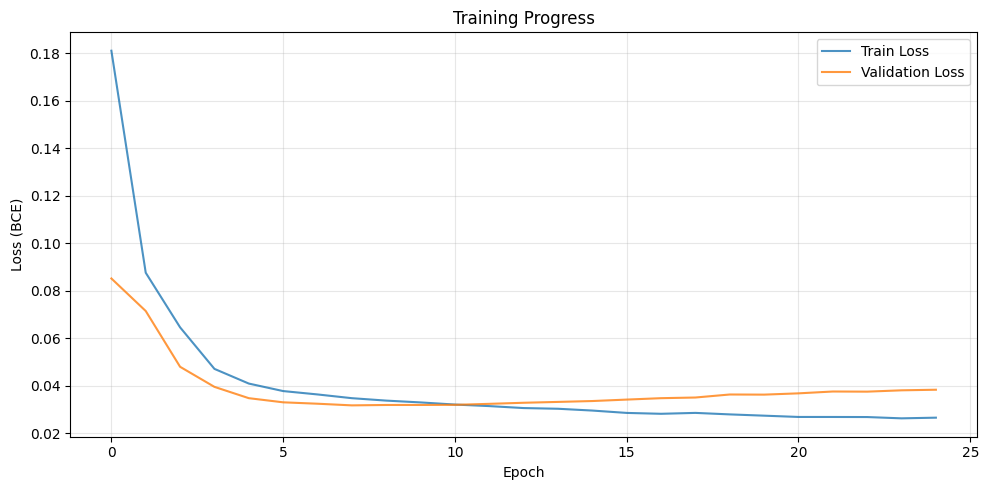

In [37]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Music Generation

In [38]:
# Load best model (if available)
best_model_path = DATA_DIR / "best_model.pt"

if best_model_path.exists():
    try:
        checkpoint = torch.load(best_model_path, map_location=DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
        print(f"  Validation loss: {checkpoint['val_loss']:.4f}")
    except Exception as e:
        print(f"Warning: Could not load model: {e}")
        print("Using current model weights (may be untrained)")
else:
    print("No saved model found at:", best_model_path)
    print("Run training (cells above) first, or use current model weights.")

Loaded best model from epoch 8
  Validation loss: 0.0318


In [39]:
@torch.no_grad()
def generate_music(model: nn.Module, seed_sequence: np.ndarray,
                   num_frames: int, temperature: float = 1.0,
                   device: torch.device = DEVICE) -> np.ndarray:
    """
    Generate music from a seed sequence.
    
    Args:
        model: Trained model (outputs logits, not probabilities)
        seed_sequence: Initial sequence (seq_len, num_pitches)
        num_frames: Number of frames to generate
        temperature: Sampling temperature (higher = more random)
        
    Returns:
        Generated piano roll (seed_len + num_frames, num_pitches) with values in [0, 1]
    """
    model.eval()
    
    # Prepare seed
    current_seq = torch.FloatTensor(seed_sequence).unsqueeze(0).to(device)
    
    # Start with seed frames (each frame individually)
    generated = list(seed_sequence)  # List of (88,) arrays
    
    # Initialize hidden state
    hidden = model.init_hidden(1, device)
    
    # Generate frames autoregressively
    for _ in tqdm(range(num_frames), desc="Generating"):
        # Forward pass - model outputs LOGITS
        logits, hidden = model(current_seq, hidden)
        
        # Get last frame logits and apply temperature
        next_logits = logits[0, -1].cpu().numpy()
        
        if temperature != 1.0:
            next_logits = next_logits / temperature
        
        # Convert logits to probabilities with sigmoid
        next_probs = 1 / (1 + np.exp(-next_logits))
        
        # Sample based on probabilities
        binary_frame = (np.random.random(next_probs.shape) < next_probs).astype(np.float32)
        next_frame = binary_frame * next_probs  # Keep velocity for active notes
        
        generated.append(next_frame)
        
        # Update sequence (sliding window)
        next_tensor = torch.FloatTensor(next_frame).unsqueeze(0).unsqueeze(0).to(device)
        current_seq = torch.cat([current_seq[:, 1:, :], next_tensor], dim=1)
    
    return np.array(generated)  # Shape: (seed_len + num_frames, 88)

In [ ]:
# Diagnose what's in the generated output
print("="*60)
print("GENERATED OUTPUT ANALYSIS")
print("="*60)

seed_part = generated_roll[:SEQUENCE_LENGTH]
generated_part = generated_roll[SEQUENCE_LENGTH:]

print(f"\nSEED portion (first {SEQUENCE_LENGTH} frames):")
print(f"  Non-zero values: {(seed_part > 0.1).sum()}")
print(f"  Max value: {seed_part.max():.3f}")
print(f"  Notes per frame (avg): {(seed_part > 0.3).sum(axis=1).mean():.2f}")

print(f"\nGENERATED portion ({len(generated_part)} frames):")
print(f"  Non-zero values: {(generated_part > 0.1).sum()}")
print(f"  Max value: {generated_part.max():.3f}")
print(f"  Notes per frame (avg): {(generated_part > 0.3).sum(axis=1).mean():.2f}")

# Check if generation is dying out over time
if len(generated_part) > 100:
    first_100 = generated_part[:100]
    last_100 = generated_part[-100:]
    print(f"\n  First 100 frames - notes/frame: {(first_100 > 0.3).sum(axis=1).mean():.2f}")
    print(f"  Last 100 frames - notes/frame: {(last_100 > 0.3).sum(axis=1).mean():.2f}")

if generated_part.max() < 0.1:
    print("\n⚠️  WARNING: Generated portion is nearly silent!")
    print("   The model may be outputting very low probabilities.")
    print("   Try: lower temperature (0.5) or check model training.")

In [64]:
# Generate music
GENERATION_LENGTH = 480  # 30 seconds at 16 fps
TEMPERATURE = 0.8       # Slightly lower for more coherent output

# Use beginning of first training piano roll as seed
#seed = piano_rolls_by_split["train"][0][:SEQUENCE_LENGTH]
seed = np.zeros((SEQUENCE_LENGTH, NUM_PITCHES), dtype=np.float32)
for i in range(0, SEQUENCE_LENGTH, 8):
    num_notes = random.randint(2, 4)
    pitches = random.sample(range(30, 60), num_notes)
    for p in pitches:
        seed[i:i+random.randint(4,12), p] = random.uniform(0.5, 1.0)

print(f"Generating {GENERATION_LENGTH} frames (~{GENERATION_LENGTH/MIDI_CONFIG['fs']:.1f} seconds)...")

generated_roll = generate_music(
    model, seed, GENERATION_LENGTH, 
    temperature=TEMPERATURE, device=DEVICE
)

print(f"Generated shape: {generated_roll.shape}")

Generating 480 frames (~30.0 seconds)...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]

Generated shape: (544, 88)


In [55]:
# Verify: Is this generated or memorized?
print("="*60)
print("GENERATION VERIFICATION")
print("="*60)

# The generated output consists of: seed (from training) + generated (by model)
seed_length = SEQUENCE_LENGTH
generated_part = generated_roll[seed_length:]  # Skip the seed

# Compare with the original training file the seed came from
original = piano_rolls_by_split["train"][0]
original_continuation = original[seed_length:seed_length + len(generated_part)]

print(f"\nSeed: first {seed_length} frames ({seed_length/MIDI_CONFIG['fs']:.1f}s) from training data")
print(f"Generated: {len(generated_part)} frames ({len(generated_part)/MIDI_CONFIG['fs']:.1f}s) by model")

if len(original_continuation) > 0:
    # Compute correlation
    min_len = min(len(generated_part), len(original_continuation))
    gen_flat = generated_part[:min_len].flatten()
    orig_flat = original_continuation[:min_len].flatten()
    
    correlation = np.corrcoef(gen_flat, orig_flat)[0, 1]
    
    # Compute exact match percentage
    threshold = 0.3
    gen_binary = (generated_part[:min_len] > threshold).astype(int)
    orig_binary = (original_continuation[:min_len] > threshold).astype(int)
    exact_match = (gen_binary == orig_binary).mean() * 100
    
    print(f"\nComparison with original training file continuation:")
    print(f"  Correlation: {correlation:.3f}")
    print(f"  Binary match: {exact_match:.1f}%")
    
    print(f"\nInterpretation:")
    if correlation > 0.9:
        print("  ⚠️  HIGH correlation - model likely memorized this piece")
    elif correlation > 0.7:
        print("  ⚡ MODERATE correlation - model learned patterns but adds variation")
    elif correlation > 0.5:
        print("  ✓  LOW-MODERATE correlation - mix of learned patterns and novelty")
    else:
        print("  ✓  LOW correlation - genuinely novel generation")

# Also check against ALL training files
print(f"\nChecking against all {len(piano_rolls_by_split['train'])} training files...")
max_corr = 0
max_corr_idx = 0

for idx, train_roll in enumerate(piano_rolls_by_split["train"]):
    if len(train_roll) > seed_length:
        compare_len = min(len(generated_part), len(train_roll) - seed_length)
        if compare_len > 100:
            train_portion = train_roll[seed_length:seed_length + compare_len]
            corr = np.corrcoef(
                generated_part[:compare_len].flatten(),
                train_portion.flatten()
            )[0, 1]
            if not np.isnan(corr) and corr > max_corr:
                max_corr = corr
                max_corr_idx = idx

print(f"  Highest correlation: {max_corr:.3f} (with training file #{max_corr_idx})")
if max_corr > 0.8:
    print("  ⚠️  Model may be reproducing training data")
else:
    print("  ✓  No strong match with any training file")

GENERATION VERIFICATION

Seed: first 64 frames (4.0s) from training data
Generated: 480 frames (30.0s) by model

Comparison with original training file continuation:
  Correlation: nan
  Binary match: 95.0%

Interpretation:
  ✓  LOW correlation - genuinely novel generation

Checking against all 50 training files...
  Highest correlation: 0.000 (with training file #0)
  ✓  No strong match with any training file


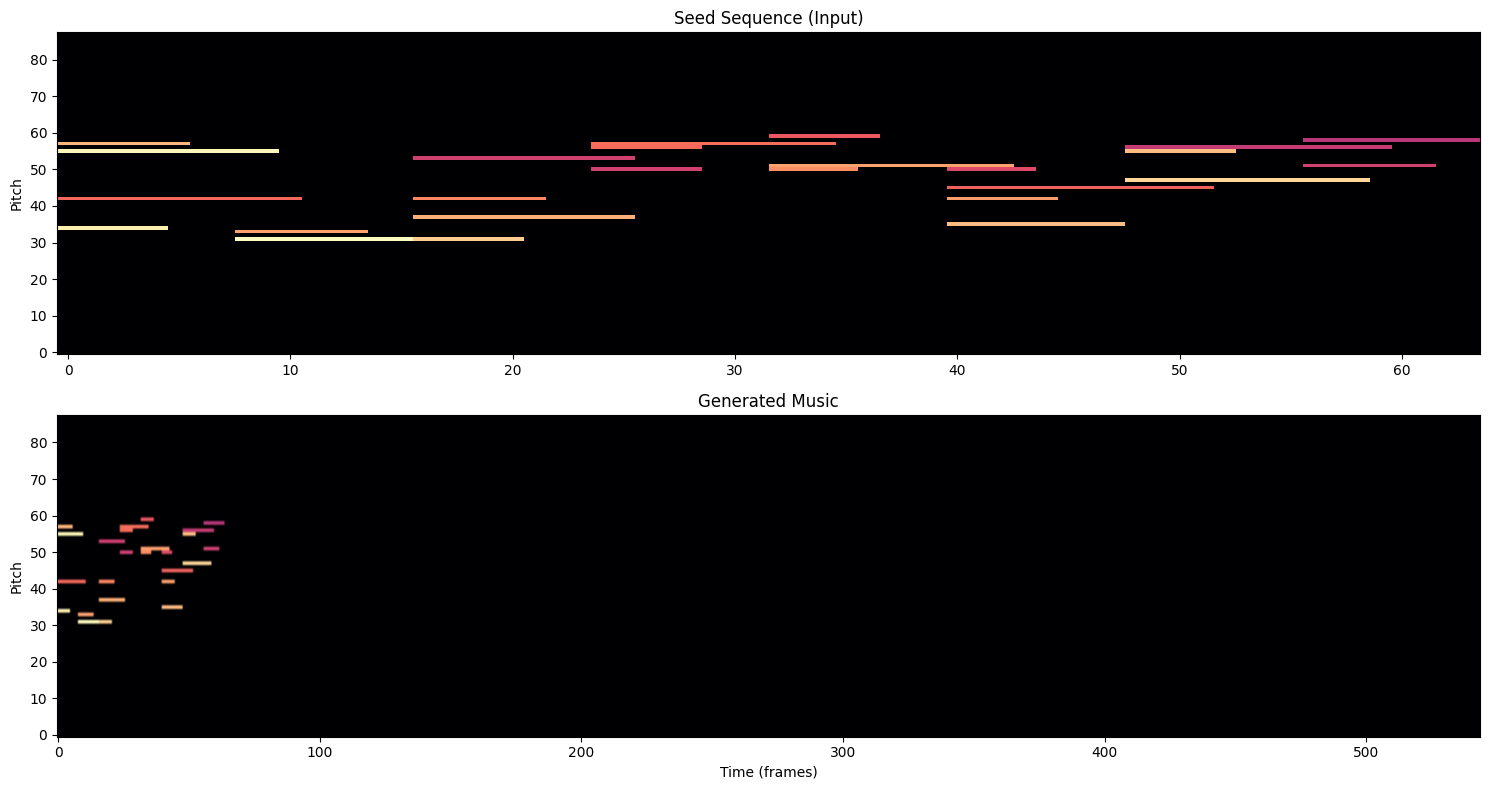

In [65]:
# Visualize generated music
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Original seed
axes[0].imshow(seed.T, aspect='auto', origin='lower', cmap='magma')
axes[0].set_title('Seed Sequence (Input)')
axes[0].set_ylabel('Pitch')

# Generated continuation
axes[1].imshow(generated_roll.T, aspect='auto', origin='lower', cmap='magma')
axes[1].set_title('Generated Music')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Pitch')

plt.tight_layout()
plt.show()

## 8. Export to MIDI

In [66]:
# Create output directory and save generated music as MIDI
OUTPUT_DIR = DATA_DIR / "generated"
OUTPUT_DIR.mkdir(exist_ok=True)

output_midi_path = OUTPUT_DIR / "generated_music.mid"

piano_roll_to_midi(
    generated_roll, 
    MIDI_CONFIG, 
    output_midi_path,
    velocity_threshold=0.3
)

print(f"\nGenerated MIDI saved to: {output_midi_path}")
print("You can open this file with any MIDI player or DAW.")


Generated MIDI saved to: midi_data/generated/generated_music.mid
You can open this file with any MIDI player or DAW.


## 8. Play MIDI Audio

Play generated MIDI directly in the notebook using audio synthesis.

In [62]:
# Audio playback utilities
from IPython.display import Audio, display

# Check if FluidSynth is available for high-quality synthesis
FLUIDSYNTH_AVAILABLE = False
try:
    import fluidsynth
    FLUIDSYNTH_AVAILABLE = True
    print("FluidSynth available - using high-quality synthesis")
except ImportError:
    print("FluidSynth not available - using basic sine wave synthesis")
    print("For better audio quality, install FluidSynth:")
    print("  macOS:  brew install fluid-synth && pip install pyfluidsynth")
    print("  Ubuntu: apt install fluidsynth && pip install pyfluidsynth")


def play_piano_roll(piano_roll: np.ndarray, config: dict, 
                    sample_rate: int = 22050) -> Audio:
    """
    Convert piano roll to audio and create playable Audio widget.
    
    Args:
        piano_roll: Array of shape (time_steps, num_pitches)
        config: MIDI configuration dictionary
        sample_rate: Audio sample rate (Hz)
        
    Returns:
        IPython Audio widget
    """
    # Create temporary MIDI
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)
    
    frame_duration = 1.0 / config["fs"]
    velocity_threshold = 0.3
    active_notes = {}
    
    for frame_idx, frame in enumerate(piano_roll):
        current_time = frame_idx * frame_duration
        
        for pitch_idx, velocity in enumerate(frame):
            midi_pitch = pitch_idx + config["min_pitch"]
            is_note_on = velocity > velocity_threshold
            
            if midi_pitch in active_notes:
                if not is_note_on:
                    start_time, start_vel = active_notes.pop(midi_pitch)
                    note = pretty_midi.Note(
                        velocity=int(start_vel * 127),
                        pitch=midi_pitch,
                        start=start_time,
                        end=current_time
                    )
                    piano.notes.append(note)
            else:
                if is_note_on:
                    active_notes[midi_pitch] = (current_time, velocity)
    
    # Close remaining notes
    end_time = len(piano_roll) * frame_duration
    for midi_pitch, (start_time, velocity) in active_notes.items():
        note = pretty_midi.Note(
            velocity=int(velocity * 127),
            pitch=midi_pitch,
            start=start_time,
            end=end_time
        )
        piano.notes.append(note)
    
    midi.instruments.append(piano)
    
    # Synthesize audio
    if FLUIDSYNTH_AVAILABLE:
        audio_data = midi.fluidsynth(fs=sample_rate)
    else:
        audio_data = midi.synthesize(fs=sample_rate)
    
    return Audio(audio_data, rate=sample_rate)


def play_midi_file(midi_path: Path, sample_rate: int = 22050) -> Audio:
    """Load and play a MIDI file."""
    midi = pretty_midi.PrettyMIDI(str(midi_path))
    
    if FLUIDSYNTH_AVAILABLE:
        audio_data = midi.fluidsynth(fs=sample_rate)
    else:
        audio_data = midi.synthesize(fs=sample_rate)
    
    return Audio(audio_data, rate=sample_rate)

FluidSynth not available - using basic sine wave synthesis
For better audio quality, install FluidSynth:
  macOS:  brew install fluid-synth && pip install pyfluidsynth
  Ubuntu: apt install fluidsynth && pip install pyfluidsynth


In [67]:
# Play ONLY the generated portion (skip the seed)
print("Playing ONLY the model-generated portion (no seed)...")
print(f"  Skipping first {SEQUENCE_LENGTH} frames ({SEQUENCE_LENGTH/MIDI_CONFIG['fs']:.1f}s) = the seed")
print(f"  Playing {len(generated_roll) - SEQUENCE_LENGTH} frames ({(len(generated_roll) - SEQUENCE_LENGTH)/MIDI_CONFIG['fs']:.1f}s) = generated by model")

generated_only = generated_roll[SEQUENCE_LENGTH:]  # Skip seed
play_piano_roll(generated_only, MIDI_CONFIG)

Playing ONLY the model-generated portion (no seed)...
  Skipping first 64 frames (4.0s) = the seed
  Playing 480 frames (30.0s) = generated by model


/Users/chrigel/Documents/workspace/private/bfh/midi-gen/venv/lib/python3.14/site-packages/pretty_midi/pretty_midi.py:985: RuntimeWarning: invalid value encountered in divide
  synthesized /= np.abs(synthesized).max()
/Users/chrigel/Documents/workspace/private/bfh/midi-gen/venv/lib/python3.14/site-packages/IPython/lib/display.py:189: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


In [63]:
# Play a sample from the training data (first 10 seconds)
print("Playing training sample (first 10 seconds)...")
sample_frames = 10 * MIDI_CONFIG["fs"]  # 10 seconds
training_sample = piano_rolls_by_split["train"][0][:sample_frames]
play_piano_roll(training_sample, MIDI_CONFIG)

Playing training sample (first 10 seconds)...


In [68]:
# Play the generated music
print("Playing generated music...")
play_piano_roll(generated_roll, MIDI_CONFIG)

Playing generated music...


In [69]:
# Generate multiple samples with different temperatures
temperatures = [0.5, 0.8, 1.0, 1.2]

for temp in temperatures:
    print(f"\nGenerating with temperature {temp}...")
    
    gen_roll = generate_music(
        model, seed, GENERATION_LENGTH,
        temperature=temp, device=DEVICE
    )
    
    output_path = OUTPUT_DIR / f"generated_temp_{temp}.mid"
    piano_roll_to_midi(gen_roll, MIDI_CONFIG, output_path)

print(f"\nAll generated files saved to: {OUTPUT_DIR}")


Generating with temperature 0.5...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]


Generating with temperature 0.8...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]


Generating with temperature 1.0...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]


Generating with temperature 1.2...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]


All generated files saved to: midi_data/generated


## 9. Interactive Generation (Optional)

In [ ]:
def generate_from_random_seed(model: nn.Module, 
                              duration_seconds: float = 30,
                              temperature: float = 0.8) -> Path:
    """
    Generate music from a random initial note pattern.
    
    Returns:
        Path to generated MIDI file
    """
    # Create random seed with sparse notes
    seed = np.zeros((SEQUENCE_LENGTH, NUM_PITCHES), dtype=np.float32)
    
    # Add some random starting notes
    for i in range(0, SEQUENCE_LENGTH, 8):
        # Random chord (2-4 notes)
        num_notes = random.randint(2, 4)
        pitches = random.sample(range(30, 60), num_notes)  # Middle range
        for p in pitches:
            velocity = random.uniform(0.5, 1.0)
            duration = random.randint(4, 12)
            for j in range(min(duration, SEQUENCE_LENGTH - i)):
                seed[i + j, p] = velocity
    
    # Generate
    num_frames = int(duration_seconds * MIDI_CONFIG["fs"])
    generated = generate_music(model, seed, num_frames, temperature, DEVICE)
    
    # Save
    timestamp = int(random.random() * 100000)
    output_path = OUTPUT_DIR / f"random_gen_{timestamp}.mid"
    piano_roll_to_midi(generated, MIDI_CONFIG, output_path)
    
    return output_path

In [ ]:
# Generate a random piece
random_output = generate_from_random_seed(
    model, 
    duration_seconds=20,
    temperature=0.9
)
print(f"Random generation saved to: {random_output}")

## Summary

This notebook implements:

1. **Data Pipeline**: Load ADL Piano MIDI dataset with official train/val/test splits
2. **Preprocessing**: Convert MIDI to piano roll representation (88 keys, 16 fps)
3. **Model**: 3-layer LSTM with ~6M parameters for polyphonic music
4. **Training**: BCE loss, AdamW optimizer, learning rate scheduling
5. **Generation**: Autoregressive sampling with temperature control
6. **Export**: Convert generated sequences back to playable MIDI files

### Data Split Strategy

Using random splits ensures:
- **No data leakage**: Same piece never appears in multiple splits
- **Reproducibility**: Standard benchmark splits
- **Fair evaluation**: Test set truly unseen during training

### Tips for Better Results

- **More epochs**: 100+ epochs with early stopping for better convergence
- **Hyperparameter tuning**: Experiment with hidden_size (256-1024), num_layers (2-4)
- **Temperature**: Lower (~0.6) for coherent output, higher (~1.2) for creativity
- **Sequence length**: Longer sequences capture more musical structure

### Resources

- [ADL Piano MIDI](https://github.com/lucasnfe/adl-piano-midi)
- [Lakh MIDI Dataset](https://colinraffel.com/projects/lmd/)
- [Aria-MIDI on HuggingFace](https://huggingface.co/datasets/loubb/aria-midi)